# 1. Noramalize Accel & Pick the peak and valley of the normalized accele signal

In [2]:
from typing import Tuple, Union

import numpy as np
from scipy import signal

def filter_acceleration(acceleration: np.ndarray, frequency: float = 400, **kwargs) -> (np.ndarray, np.ndarray):
    """
    This function filters then normalises and centers around 0 the input 3D acceleration

    Parameters
    ----------
    acceleration : N,3 shaped numpy array,
        Contains accelerometer data sequence in m/s^2 un-normalised with gravity offset
    frequency : float, default = 400 hz
        Frequency at which the data has been acquired

    kwargs : dict:
    - gravity : float. Earth's gravity value, default 9.7 m/s^2
    - butter_order : order of the low pass Butterworth filter. default: 2
    - cutoff_step_frequency : float. Represents the number of step one can walk in a second. default: 2 hz
    - filter_all_accelerations : is set to True, will filter along each axis

    Returns
    -------
    acceleration_norm : N,1 np.ndarray
        The filtered acceleration norm

    acceleration_sequence:  N,3 np.ndarray, optional
        The filtered acceleration axis. Set the argument filter_all_accelerations=True to have it.
        else returns the input.
    """

    gravity = kwargs.get("gravity", 9.7)
    delta_time = 1.0 / frequency  # seconds / sample
    low_pass_cutoff = kwargs.get("cutoff_step_frequency", 2.0)  # hz
    butter_order = kwargs.get("butter_order", 2)  # 2nd order butterworth

    # noinspection PyTupleAssignmentBalance
    lp_numer, lp_denom = signal.butter(butter_order, 2.0 * low_pass_cutoff * delta_time, "low")
    
    # normalise by gravity
    if len(acceleration.shape) > 1:
        acceleration = np.linalg.norm(acceleration, axis=1)
    # acceleration /= gravity

    # center the acce norm around 0
    acceleration = signal.filtfilt(lp_numer, lp_denom, acceleration) - np.mean(acceleration)
    return acceleration


def detect_steps(acceleration: np.ndarray, acceleration_threshold: float, frequency: float, **kwargs) -> \
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """

    This function calls :func: `filter_acceleration` function by itself.

    Parameters
    ----------
    acceleration : N,3 shaped np.ndarray,
        Contains accelerometer data sequence in m/s^2 un-normalised with an gravity offset
    acceleration_threshold : float, default : 0.07
        The threshold at which the acceleration can be considered as part of a step.

    Returns
    -------
    acceleration_norm: np.ndarray
        The filtered acceleration norm
    zero_crossing: np.ndarray
        Indices where the normalised centered acceleration crosses 0.
    peaks: np.ndarray
        Indices where the local acceleration peaks are located
    valleys: np.ndarray
        Indices where the local acceleration peaks are located
    """

    acceleration = filter_acceleration(acceleration, frequency=frequency, **kwargs)
    zero_crossing = np.where((acceleration[:-1] * acceleration[1:]) < 0)[0]

    # delete the first index element if the wave is negative to ensure the acceleration goes positive then negative
    if acceleration[zero_crossing[0]] > 0 and acceleration[zero_crossing[0] + 1] < 0:
        zero_crossing = zero_crossing[1:]
    
    # t_plus and t_minus are respectively times where the signal transits from negative, positive to positive, negative
    peaks = []
    valleys = []
    for t_plus, t_minus in zip(zero_crossing[::2], zero_crossing[1::2]):
        max_index = np.argmax(acceleration[t_plus: t_minus])
        peaks.append(max_index + t_plus)

    for t_plus, t_minus in zip(zero_crossing[2::2], zero_crossing[1::2]):
        min_index = np.argmin(acceleration[t_minus: t_plus])
        valleys.append(min_index + t_minus)

    peaks = np.array(peaks, dtype=int)
    valleys = np.array(valleys, dtype=int)

    indices = np.where(acceleration[peaks] > acceleration_threshold)[0]
    peaks = peaks[indices]
    indices = np.where(acceleration[valleys] < -acceleration_threshold)[0]
    valleys = valleys[indices]

    if len(peaks) == 0:
        print("Warning: no acceleration peaks found during sequence")
    if len(valleys) == 0:
        print("Warning: no acceleration valleys found during sequence")

    return acceleration, zero_crossing, peaks, valleys


# 2. Estimate step length

$$
step\_length = k \cdot \sqrt[4]{a_{max}-a_{min}}
$$

Reference

- Using the ADXL202 in Pedometer and Personal Navigation Applications, Harvey Weinberg, 2002
- A Pedestrian Dead Reckoning Method for Head-Mounted Sensors, Xinyu et al, 2020
- https://github.com/anisghaoui/humolire

In [3]:
def compute_step_length(accelerometer_norm: Union[Tuple, np.ndarray], weinberg_gain: float) -> float:
    """
    # Article:  Xinyu Hou 2020 (eq 7, 8, 9, 10, 11)
    Weingberg method (eq 8):
    weinberg_gain is K in the formula

    Parameters
    ----------
    accelerometer_norm : array-like
        The function will find the map and min of this iterable. In m/s^2
    weinberg_gain :
        The gain is the empirical value that is  proportional to the pedestrian leg length

    Returns
    -------
    step_length : float
        The length of the walked step in meters
    """
    step_length = weinberg_gain * np.power(np.max(accelerometer_norm) - np.min(accelerometer_norm), 1.0 / 4)
    return step_length

In [4]:
import matplotlib.pyplot as plt

def single_step_display(acceleration_threshold, weinberg_gain, time, acce, gyro, refs_timing, frequency, ax, title, subplot_at):
    acce_norm, zero, _max, _min = detect_steps(acce, acceleration_threshold=acceleration_threshold, frequency=frequency)
    
    if not isinstance(ax, np.ndarray):  # 단일 Axes 객체인지 확인
        plt.plot(time, acce_norm)
        plt.plot(time[zero], acce_norm[zero], 'or', markersize=5)
        plt.plot(time[_min].T, acce_norm[_min], 'ob', markersize=5)
        plt.plot(time[_max].T, acce_norm[_max], 'og', markersize=5)
        plt.plot(time, np.zeros(time.shape), 'y*', markersize=1)
        plt.legend(["filtered acceleration", "zero crossing", "valleys", "peaks"])
        plt.title(label=title)
        plt.margins(0.0)
        plt.grid()
    else:
        x, y = subplot_at
        ax[x, y].plot(time, acce_norm)
        ax[x, y].plot(time[zero], acce_norm[zero], 'or', markersize=5)
        ax[x, y].plot(time[_min].T, acce_norm[_min], 'ob', markersize=5)
        ax[x, y].plot(time[_max].T, acce_norm[_max], 'og', markersize=5)
        ax[x, y].plot(time, np.zeros(time.shape), 'y*', markersize=1)
        ax[x, y].legend(["filtered acceleration", "zero crossing", "valleys", "peaks"])
        ax[x, y].set_title(label=title)
        ax[x, y].grid()
        ax[x, y].margins(0.0)

    # print(acce_norm)
    # print(_max)
    # print(_min)
    # print(zero)

    results = []

    # 0 2 
    for index, (max_idx, min_idx) in enumerate(zip(_max, _min)):
        results.append({
            "step_length": compute_step_length((acce_norm[max_idx], acce_norm[min_idx]), weinberg_gain=weinberg_gain),
            "start": zero[2 * index],
            "middle": zero[2 * index + 1],
            "end": zero[2 * index + 2]
        })

    return results

# 3. Result of estimated step length

- Weinberg_gain, accelerometer_threshold 파라미터를 잘 설정해줘야 함.

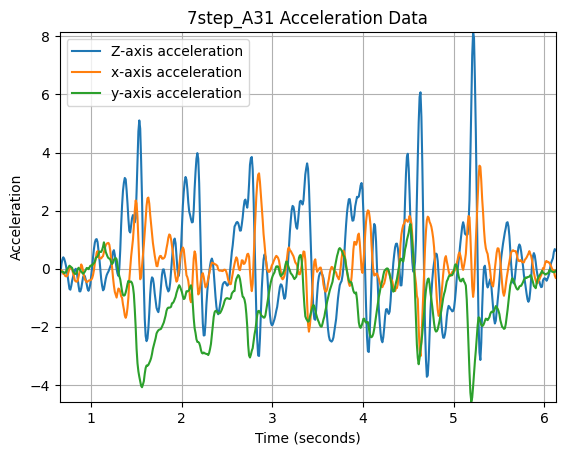

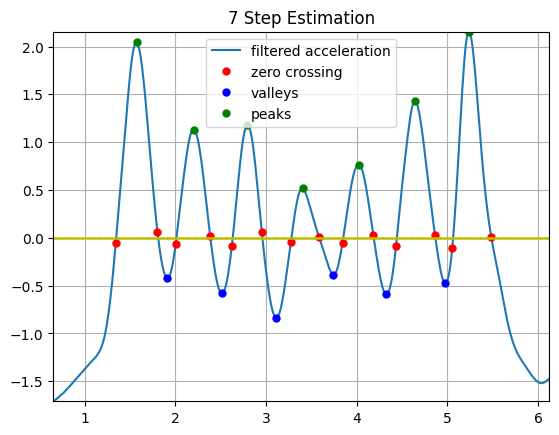

size of steps:  6
total:  4.090248421786892


In [5]:
import pandas as pd

acc_df = pd.read_csv("../data/7step_A31/Accelerometer.csv")
gyro_df = pd.read_csv("../data/7step_A31/GyroscopeUncalibrated.csv")
mag_df = pd.read_csv("../data/7step_A31/MagnetometerUncalibrated.csv")

plt.plot(acc_df['seconds_elapsed'], acc_df['z'], label="Z-axis acceleration")
plt.plot(acc_df['seconds_elapsed'], acc_df['x'], label="x-axis acceleration")
plt.plot(acc_df['seconds_elapsed'], acc_df['y'], label="y-axis acceleration")
plt.title("7step_A31 Acceleration Data")
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration")
plt.legend()
plt.grid()
plt.margins(0.0)
plt.show()

fig, ax = plt.subplots(1,1)
steps = single_step_display(
    acceleration_threshold=0.01,
    weinberg_gain=0.6,
    time=acc_df['seconds_elapsed'].to_numpy(),
    acce=acc_df.drop(columns=['seconds_elapsed', 'time']).to_numpy(),
    gyro=gyro_df.drop(columns=['seconds_elapsed', 'time']).to_numpy(),
    refs_timing=acc_df['seconds_elapsed'].to_numpy(),
    frequency=100,
    ax=ax,
    title="7 Step Estimation",
    subplot_at=(0,0)
)
plt.show()

print('size of steps: ', len(steps))
print('total: ', sum(step['step_length'] for step in steps))


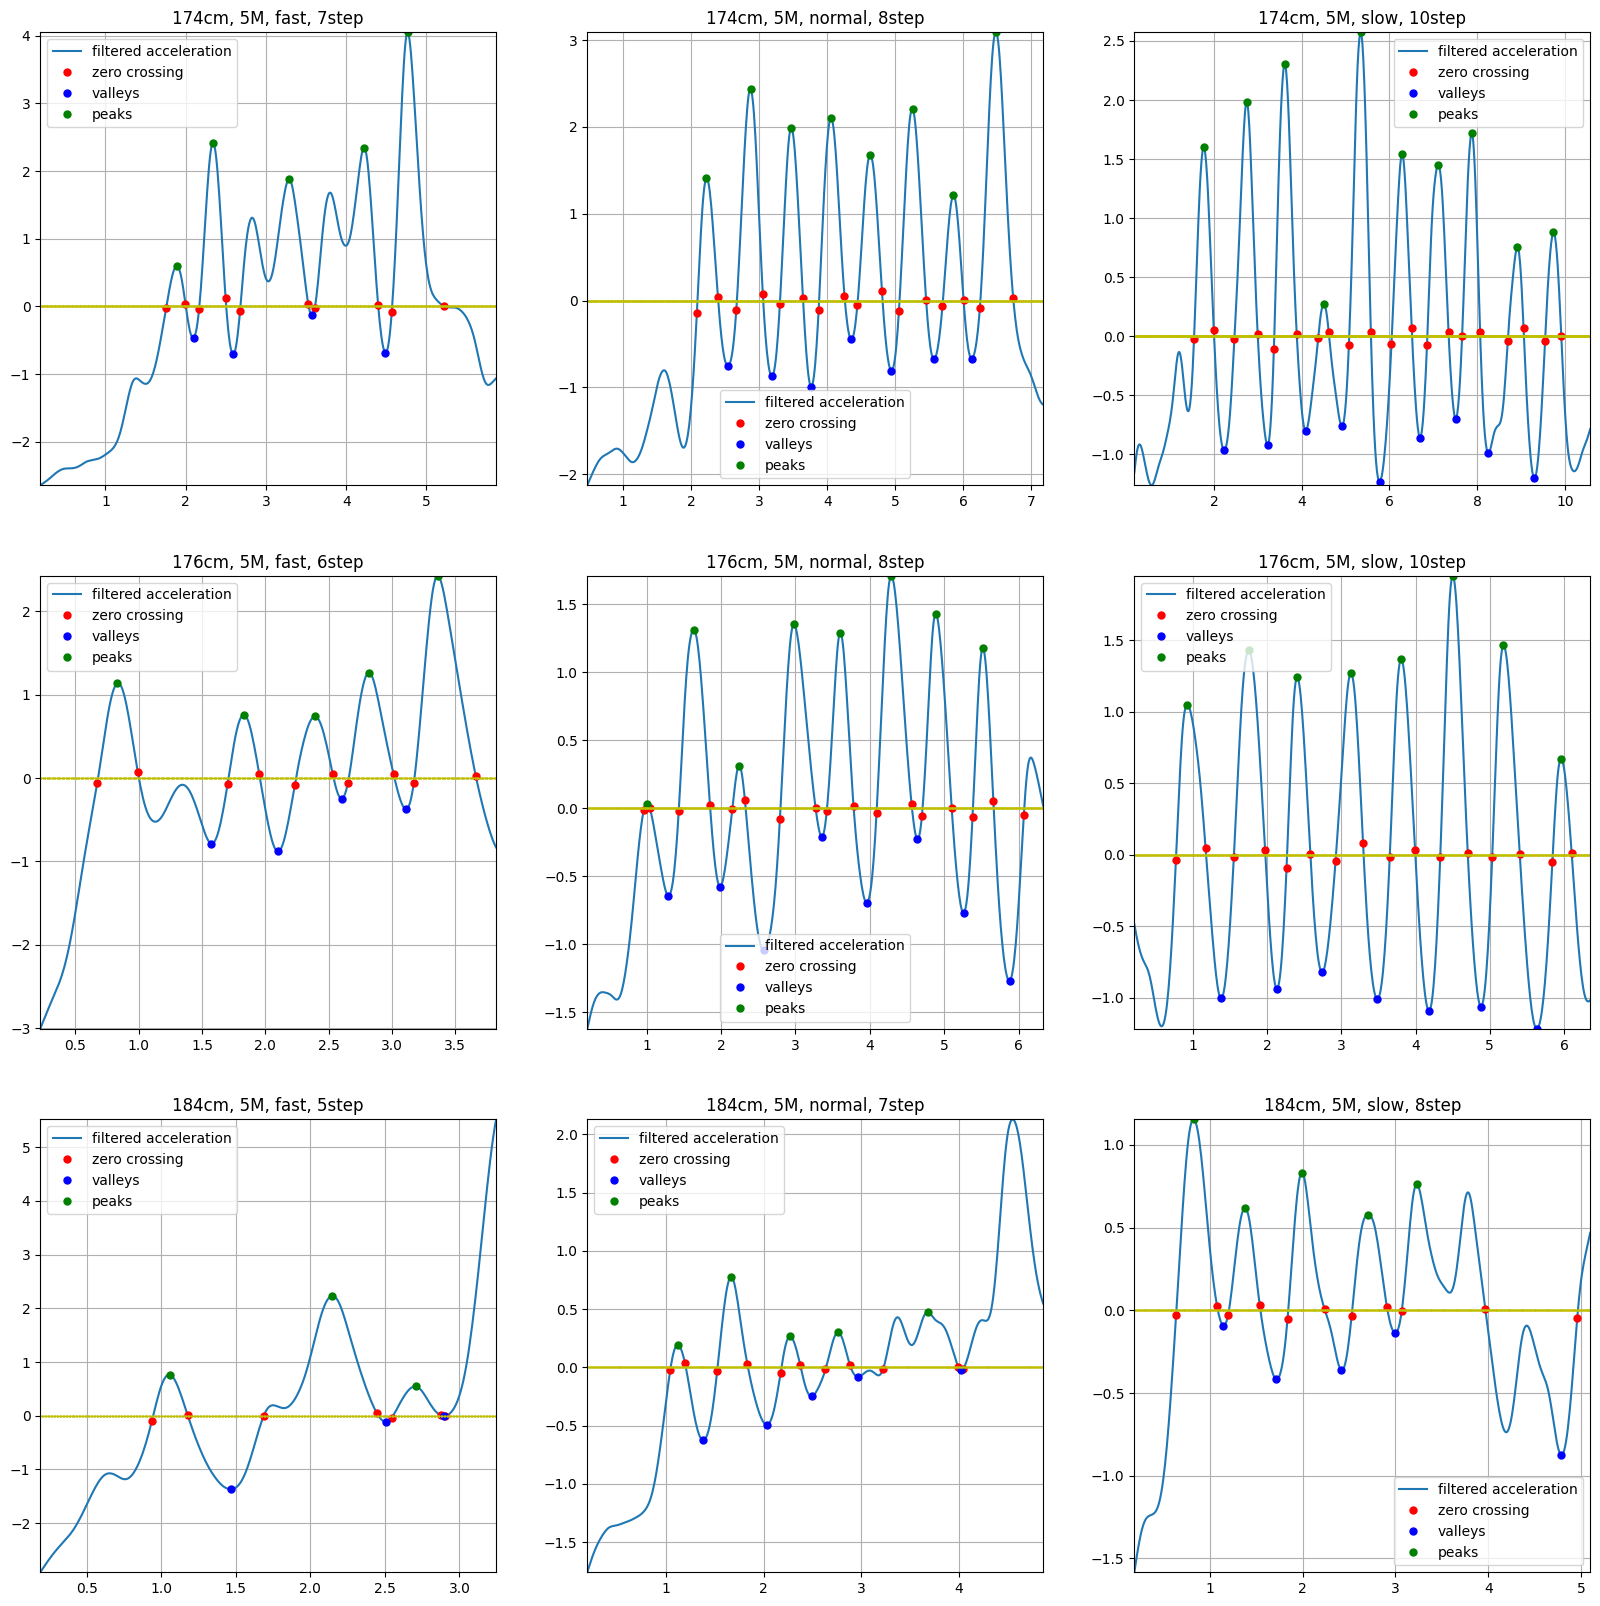

0th - 174cm, 5M, fast, 7step
157 ,  198 , 198 ,  249 , 249 ,  342 , 342 ,  438 , 
1th - 174cm, 5M, normal, 8step
161 ,  219 , 219 ,  283 , 283 ,  340 , 340 ,  397 , 397 ,  458 , 458 ,  522 , 522 ,  577 , 
2th - 174cm, 5M, slow, 10step
136 ,  228 , 228 ,  318 , 318 ,  419 , 419 ,  489 , 489 ,  586 , 586 ,  667 , 667 ,  747 , 747 ,  851 , 851 ,  936 , 
3th - 176cm, 5M, fast, 6step
45 ,  148 , 148 ,  201 , 201 ,  243 , 243 ,  295 , 
4th - 176cm, 5M, normal, 8step
76 ,  123 , 123 ,  195 , 195 ,  259 , 259 ,  322 , 322 ,  389 , 389 ,  450 , 450 ,  518 , 518 ,  587 , 
5th - 176cm, 5M, slow, 10step
56 ,  134 , 134 ,  205 , 205 ,  271 , 271 ,  344 , 344 ,  412 , 412 ,  482 , 482 ,  563 , 
6th - 184cm, 5M, fast, 5step
75 ,  150 , 150 ,  236 , 236 ,  272 , 
7th - 184cm, 5M, normal, 7step
85 ,  133 , 133 ,  198 , 198 ,  244 , 244 ,  303 , 303 ,  385 , 
8th - 184cm, 5M, slow, 8step
45 ,  101 , 101 ,  165 , 165 ,  234 , 234 ,  288 , 288 ,  477 , 


,_,"174cm, 5M, fast, 7step","174cm, 5M, normal, 8step","174cm, 5M, slow, 10step","176cm, 5M, fast, 6step","176cm, 5M, normal, 8step","176cm, 5M, slow, 10step","184cm, 5M, fast, 5step","184cm, 5M, normal, 7step","184cm, 5M, slow, 8step"
0,acceleration_threshold,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
1,weinberg_gain,0.625,0.625,0.625,0.625,0.625,0.625,0.71,0.71,0.71
2,Truth Length,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
3,Estimated Length,3.033553,5.541973,7.017661,2.773411,5.693484,5.446991,2.348518,3.183573,3.665514
4,Length Error Rate,39.33%,10.84%,40.35%,44.53%,13.87%,8.94%,53.03%,36.33%,26.69%
5,Truth Steps,7,8,10,6,8,10,5,7,8
6,Estimated Steps,4,7,9,4,8,7,3,5,5
7,Step Error Rate,42.86%,12.50%,10.00%,33.33%,0.00%,30.00%,40.00%,28.57%,37.50%


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 파일과 메타데이터 정리
datasets = [
    {"path": "../data/7step_fast_5m_A31/Accelerometer.csv", "title": "174cm, 5M, fast, 7step", "subplot": (0, 0), "step": 7, "acceleration_threshold": 0.001, "weinberg_gain": 0.625},
    {"path": "../data/8step_normal_5m_A31/Accelerometer.csv", "title": "174cm, 5M, normal, 8step", "subplot": (0, 1), "step" : 8, "acceleration_threshold": 0.001, "weinberg_gain": 0.625},
    {"path": "../data/10step_slow_5m_A31/Accelerometer.csv", "title": "174cm, 5M, slow, 10step", "subplot": (0, 2), "step" : 10, "acceleration_threshold": 0.001, "weinberg_gain": 0.625},
    {"path": "../data/6step_fast_176cm_5m_A31/Accelerometer.csv", "title": "176cm, 5M, fast, 6step", "subplot": (1, 0), "step" : 6, "acceleration_threshold": 0.001, "weinberg_gain": 0.625},
    {"path": "../data/8step_normal_176cm_5m_A31/Accelerometer.csv", "title": "176cm, 5M, normal, 8step", "subplot": (1, 1), "step" : 8, "acceleration_threshold": 0.001, "weinberg_gain": 0.625},
    {"path": "../data/10step_slow_176cm_5m_A31/Accelerometer.csv", "title": "176cm, 5M, slow, 10step", "subplot": (1, 2), "step" : 10, "acceleration_threshold": 0.001, "weinberg_gain": 0.625},
    {"path": "../data/5step_fast_184cm_5m_A31/Accelerometer.csv", "title": "184cm, 5M, fast, 5step", "subplot": (2, 0), "step" : 5, "acceleration_threshold": 0.001, "weinberg_gain": 0.71},
    {"path": "../data/7step_normal_184cm_5m_A31/Accelerometer.csv", "title": "184cm, 5M, normal, 7step", "subplot": (2, 1), "step" : 7, "acceleration_threshold":0.001, "weinberg_gain": 0.71},
    {"path": "../data/8step_slow_184cm_5m_A31/Accelerometer.csv", "title": "184cm, 5M, slow, 8step", "subplot": (2, 2), "step" : 8, "acceleration_threshold":0.001, "weinberg_gain": 0.71}
]

# 서브플롯 설정
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

# 데이터 처리 및 결과 저장
for idx, data in enumerate(datasets):
    acc_df = pd.read_csv(data["path"])
    gyro_df = pd.read_csv(data["path"])
    
    result = single_step_display(
        acceleration_threshold=data["acceleration_threshold"],
        weinberg_gain=data["weinberg_gain"],
        time=acc_df['seconds_elapsed'].to_numpy(),
        acce=acc_df.drop(columns=['seconds_elapsed', 'time']).to_numpy(),
        gyro=gyro_df.drop(columns=['seconds_elapsed', 'time']).to_numpy(),
        refs_timing=acc_df['seconds_elapsed'].to_numpy(),
        frequency=100,
        ax=ax,
        title=data["title"],
        subplot_at=data["subplot"]
    )

    datasets[idx]["result"] = result

plt.show()

# 결과 데이터프레임 생성
summary = {
    "_": ["acceleration_threshold", "weinberg_gain", "Truth Length", "Estimated Length", "Length Error Rate", "Truth Steps", "Estimated Steps", "Step Error Rate"]
}

for idx, data in enumerate(datasets):
    title = data["title"]
    steps = data["result"]
    total_length = sum(step["step_length"] for step in steps)
    length_error_rate = abs(5.0 - total_length) / 5.0 * 100.0
    step_count = len(steps)
    step_error_rate = abs(data["step"] - step_count) / data["step"] * 100
    
    summary[title] = [data["acceleration_threshold"], data["weinberg_gain"], 5.0, total_length, f"{length_error_rate:.2f}%", data["step"], step_count, f"{step_error_rate:.2f}%"]

for idx, data in enumerate(datasets):
    print(f"{idx}th - {data["title"]}")
    steps = data["result"]
    
    for step in steps:
        print(step["start"], ", ", step["end"], ", ", end='')

    print()

pd.DataFrame(summary)

# 4. Estimated Orientation

- Since the turning action always happen along the horizontal plane that is perpendicular to the gravity,
- we can estimate the turning angle by integrating the Z-axial rotation in the vehicle-carried NED frame.

In [7]:
# Function to integrate the gyroscope readings (angular velocity) over time to estimate the heading change (turning angle)
def estimate_turning_angle(gyro_data: pd.DataFrame, frequency):
    """
    Estimates the turning angle using gyroscope data.
    
    Parameters:
    gyro_data (pd.DataFrame): DataFrame with columns 'x', 'y', 'z' representing gyroscope readings in radians per second
    frequency (float): Sampling frequency (Hz)
    
    Returns:
    float: Total turning angle (in radians) from the start
    """
    total_angle = 0.0  # Initialize total turning angle
    dt = 1.0 / frequency

    # Iterate over rows in the DataFrame
    for _, row in gyro_data.iterrows():
        gx, gy, gz = row['x'], row['y'], row['z']
        total_angle += gz * dt  # Integrate Z-axis angular velocity (yaw)

    return total_angle


# 5. Result of the estimated orientation

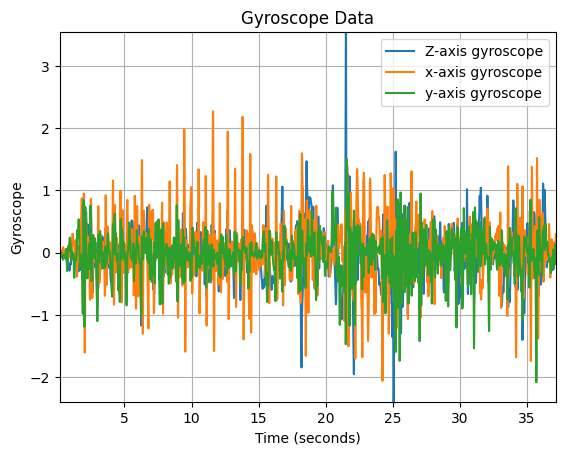

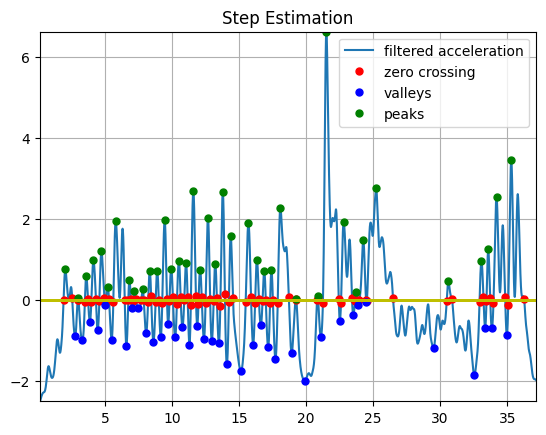

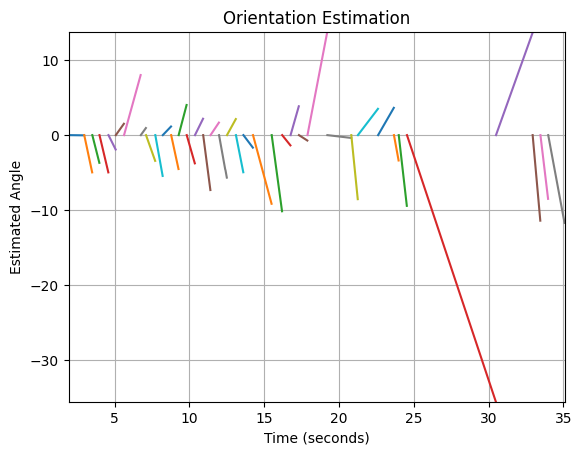

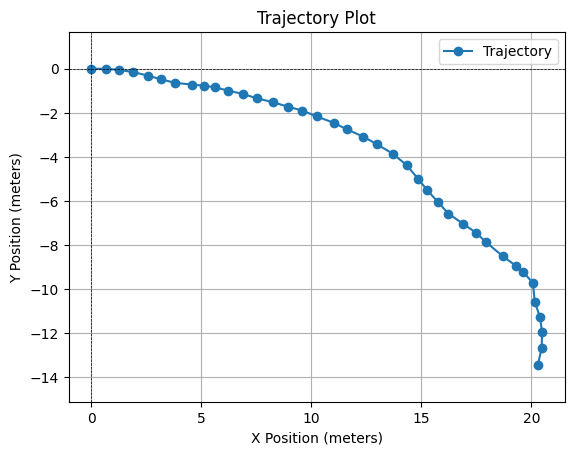

In [14]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 로드
acc_df = pd.read_csv("../data/Path1_freeOri_A31/Accelerometer.csv")
gyro_df = pd.read_csv("../data/Path1_freeOri_A31/GyroscopeUncalibrated.csv")
mag_df = pd.read_csv("../data/Path1_freeOri_A31/MagnetometerUncalibrated.csv")

# Gyroscope 데이터 시각화
plt.plot(gyro_df['seconds_elapsed'], gyro_df['z'], label="Z-axis gyroscope")
plt.plot(gyro_df['seconds_elapsed'], gyro_df['x'], label="x-axis gyroscope")
plt.plot(gyro_df['seconds_elapsed'], gyro_df['y'], label="y-axis gyroscope")
plt.title("Gyroscope Data")
plt.xlabel("Time (seconds)")
plt.ylabel("Gyroscope")
plt.legend()
plt.grid()
plt.margins(0.0)
plt.show()

# Step detection 및 Orientation Estimation
fig, ax = plt.subplots(1, 1)
steps = single_step_display(
    acceleration_threshold=0.01,
    weinberg_gain=0.6,
    time=acc_df['seconds_elapsed'].to_numpy(),
    acce=acc_df.drop(columns=['seconds_elapsed', 'time']).to_numpy(),
    gyro=gyro_df.drop(columns=['seconds_elapsed', 'time']).to_numpy(),
    refs_timing=acc_df['seconds_elapsed'].to_numpy(),
    frequency=100,
    ax=ax,
    title="Step Estimation",
    subplot_at=(0, 0)
)
plt.show()

# Orientation Plotting
time_segments = []
orientation_segments = []

# Tranjectory
x, y = 0, 0  # 초기 위치
trajectory_x = [x]
trajectory_y = [y]
current_angle = 0  # 초기 방향 (radians)

for step in steps:
    step_length = step['step_length']
    start = step['start']
    end = step['end']

    # Turning angle estimation
    result = estimate_turning_angle(gyro_data=gyro_df.iloc[start:end, :], frequency=100.0)
    
    
    # 구간별 시간 데이터 및 선형 증가 데이터 생성
    time_segment = gyro_df['seconds_elapsed'].iloc[start:end].to_numpy()
    orientation_segment = np.linspace(0, math.degrees(result), len(time_segment))
    
    time_segments.append(time_segment)
    orientation_segments.append(orientation_segment)

    # 방향 업데이트
    current_angle += result  
    
    # 새로운 위치 계산
    dx = step_length * math.cos(current_angle)
    dy = step_length * math.sin(current_angle)
    x += dx
    y += dy
    trajectory_x.append(x)
    trajectory_y.append(y)

    # print(f"StepLength: {step_length}, Start: {start}, End: {end}, Estimated Angle (radian): {result}, Estimated Angle (degree): {math.degrees(result)}")

# Plot orientation
plt.figure()
for time_segment, orientation_segment in zip(time_segments, orientation_segments):
    plt.plot(time_segment, orientation_segment, label="Estimated Orientation")

plt.title("Orientation Estimation")
plt.xlabel("Time (seconds)")
plt.ylabel("Estimated Angle")
# plt.legend()
plt.grid()
plt.margins(0.0)
plt.autoscale(enable=True, axis='y')
plt.show()

# Trajectory plot
plt.figure()
plt.plot(trajectory_x, trajectory_y, marker='o', label="Trajectory")
plt.title("Trajectory Plot")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid()
plt.legend()
plt.axis('equal')  # X, Y 축의 비율을 동일하게
plt.show()